# Hall of Fame Prediction Model

#### This notebook will construct a predictive machine learning model building upon the previous steps taken in this project

Notes: 
- The upcoming models solely consider NBA career achievements, excluding international careers, coaching roles, or anything outside of the NBA.
- I am also focusing on individual statistics, not team accomplishments. Championships, in my opinion, is the distinction that separates the top 10-15 greatest players of all time and does not have as much weight below that. Also, everyone on the winning team gets a championship ring, so it may complicate the model.
- To generally encompass the value a player produced for their team, I will include career win% and win shares instead.
- I plan to use Random Forest for my model because I think it suits my data and goal the best, but I can test other options.

#### Please see HOF_factors.md in the 'visualization' folder for an examination of several factors.

In [6832]:
# import the necessary libraries
import numpy as np
import pandas
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import joblib
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_columns', None)

In [6833]:
# Hall of Fame inductions are based on overall careers, so I need to read in my careers data
careers = pd.read_csv('careers.csv')

I need a set of eligible careers because only players that have been retired for 4 full seasons are eligible for the HOF

In [6834]:
eligible = careers[careers['last year'] <= 2019]

## Model 1: Random Forest Classifier

My first model will simply feature every explanatory variable from the data, including basic, advanced, and team stats. I expect it to work decently well because I tailored the data set towards this goal. However, some factors ignored: position and era.

In [6835]:
x = eligible.drop(columns = ['first year', 'last year', 'hof', 'player_id', 'player', 'Unnamed: 0', 'pos'])
# hopefully, this will reduce noise and be more accurate
y = eligible['hof']
sc = StandardScaler()
x = sc.fit_transform(x) # fit and transform all x variables to the proper scaling
# split into testing data and training data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(x_train, y_train)
pred1 = rfc.predict(x_test)

#### Accuracy Score:

In [6836]:
accuracy_score(y_test, pred1)

0.9805013927576601

#### Classification Report:

In [6837]:
target_names = ['Not HOF', 'HOF']
report = classification_report(y_test, pred1, target_names=target_names, output_dict=True)
pd.DataFrame(report)

,Not HOF,HOF,accuracy,macro avg,weighted avg
precision,0.985507,0.857143,0.980501,0.921325,0.979429
recall,0.994152,0.705882,0.980501,0.850017,0.980501
f1-score,0.989811,0.774194,0.980501,0.882002,0.979600
support,684.000000,34.000000,0.980501,718.000000,718.000000


#### Confusion Matrix Heatmap:

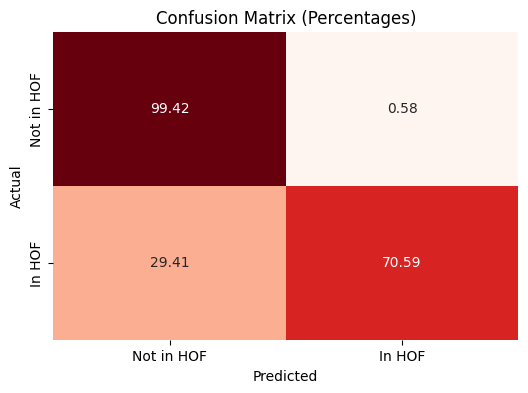

In [6838]:
confusion_mtx = confusion_matrix(y_test, pred1)
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx_percent, annot=True, fmt='.2f', cmap='Reds', cbar=False,
            xticklabels=['Not in HOF', 'In HOF'],
            yticklabels=['Not in HOF', 'In HOF'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentages)')
plt.show()

This model predicted players that missed the Hall of Fame well, but it was not very accurate in identifying the inducted players.

## Model 2: Improved Features

To uncover the most important features, I will make a bar chart to visualize which factors had the most impact

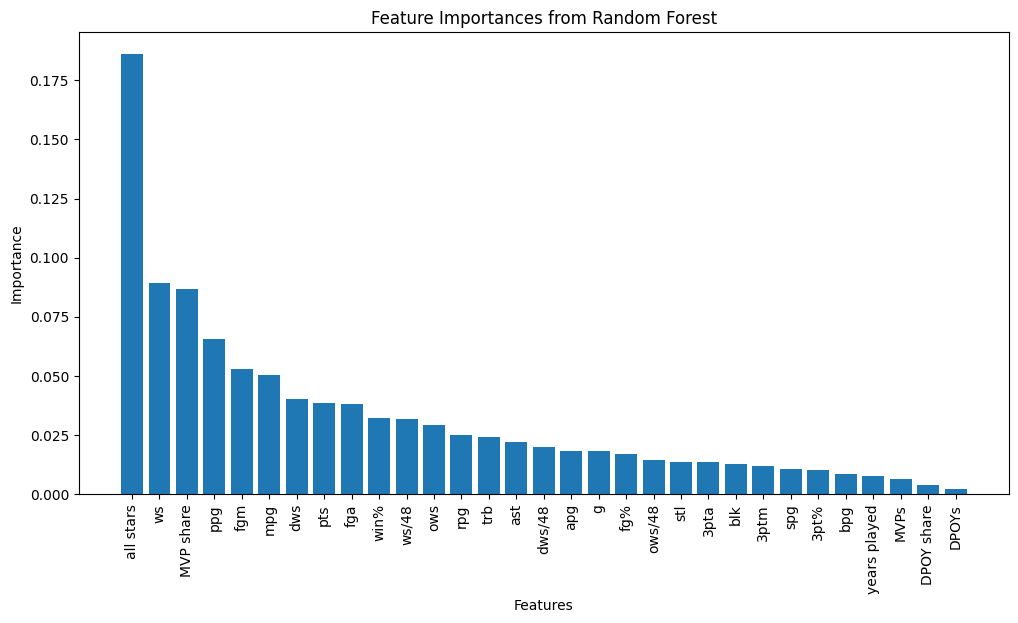

In [6839]:
# Get feature importances
feature_importances = rfc.feature_importances_
# Create a dictionary mapping feature names to their importance scores
feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, feature_importances)}
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))
# Create a bar plot to visualize feature importances
plt.figure(figsize=(12, 6))
plt.bar(sorted_feature_importance.keys(), sorted_feature_importance.values())
plt.xticks(rotation='vertical')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances from Random Forest")
plt.show()

A lot of features are inherently correlated with each other (ex: MVPs and MVP share). I will keep the one listed higher in importance.

In [6840]:
x = eligible[['all stars', 'MVP share', 'ws', 'pts', 'ws/48', 'win%', 'rpg', 'ast', 'fga', 'mpg', 'stl', 'blk', 'DPOY share']]
# hopefully, this will reduce noise and be more accurate
y = eligible['hof']
sc = StandardScaler()
x = sc.fit_transform(x) # fit and transform all x variables to the proper scaling
# split into testing data and training data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(x_train, y_train)
pred2 = rfc.predict(x_test)

#### Accuracy Score:

In [6841]:
accuracy_score(y_test, pred2)

0.9832869080779945

#### Classification Report:

In [6842]:
target_names = ['Not HOF', 'HOF']
report = classification_report(y_test, pred2, target_names=target_names, output_dict=True)
pd.DataFrame(report)

,Not HOF,HOF,accuracy,macro avg,weighted avg
precision,0.988372,0.866667,0.983287,0.927519,0.982609
recall,0.994152,0.764706,0.983287,0.879429,0.983287
f1-score,0.991254,0.812500,0.983287,0.901877,0.982789
support,684.000000,34.000000,0.983287,718.000000,718.000000


#### Confusion Matrix Heatmap:

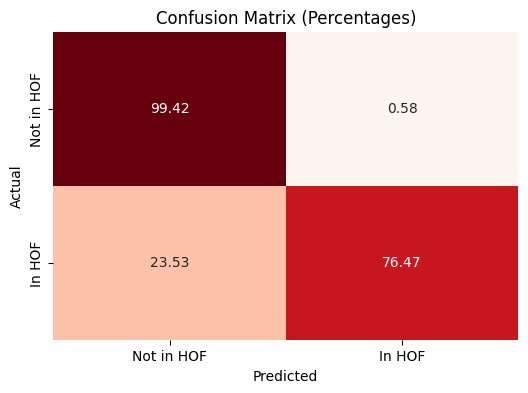

In [6843]:
confusion_mtx = confusion_matrix(y_test, pred2)
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx_percent, annot=True, fmt='.2f', cmap='Reds', cbar=False,
            xticklabels=['Not in HOF', 'In HOF'],
            yticklabels=['Not in HOF', 'In HOF'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentages)')
plt.show()

This model did slightly better than before.

## Model 3: Account for extraneous factors

Utilizing positions could make this more accurate because different positions have different expections in terms of stats. Instead of just including it with the features, I will make it an indicator variable with an encoder

Additionally, a couple changes to the data itself:
- The NBA has changed a lot in its history, so I will filter out players that retired before 1970 (I tested out a few years and this appears to be the sweet spot of recent enough data, but also enough data to train).
- Many players made it into the Hall of Fame for their international career, coaching career, or being a community leader, so I will filter for players that played a substantial amount of games

In [6883]:
eligible = eligible[eligible['years played'] > 5]
eligible = eligible[eligible['g'] > 300]
eligible_filtered = eligible[eligible['last year'] > 1970]

I will make the model with functions now so I can save and reuse the trained model. 

In [6884]:
def encode_and_scale(data, features, response_variable):
    # To account for position, I will first use OneHotEncoder
    position_column = data['pos']
    encoder = OneHotEncoder(sparse_output=False)
    # Reshape and fit-transform the position column
    position_encoded = encoder.fit_transform(position_column.values.reshape(-1, 1))
    # Get the feature names for the one-hot encoded position variables
    position_feature_names = encoder.get_feature_names_out(['pos'])
    # Create a DataFrame with the one-hot encoded position variables
    position_df = pd.DataFrame(position_encoded, columns=position_feature_names)
    # Concatenate the position DataFrame with original data
    player_id = data['player_id']
    data.reset_index(drop=True, inplace=True)
    data_with_position = pd.concat([data, position_df], axis=1)
    # add position indicators to features
    updated_features = features + list(position_df.columns)
    x = data_with_position[updated_features]
    y = data_with_position[response_variable]
    sc = StandardScaler()
    x_scaled = sc.fit_transform(x)
    return x_scaled, y, player_id

def train_random_forest(data, features, response_variable, n_estimators, save_path):
    x, y, _ = encode_and_scale(data, features, response_variable)
    rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rfc.fit(x, y)
    # Save the trained model
    joblib.dump(rfc, save_path)

def load_and_predict(saved_model_path, new_player_data, features, response_variable):
    loaded_model = joblib.load(saved_model_path)
    x, y, id = encode_and_scale(new_player_data, features, response_variable)
    predictions = loaded_model.predict(x)
    predictions_df = pd.DataFrame({'Player ID': id, 'Predicted': predictions})
    return predictions_df

I tested different features here again to see what worked best.

In [6885]:
# Train the model
features = ['all stars', 'MVPs', 'ws', 'pts', 'win%', 'trb', 'ast', 'fgm', 'mpg', 'stl', 'blk', 'DPOY share', 'ppg', 'rpg']
response = 'hof'
train_data, test_data = train_test_split(eligible_filtered, test_size=0.2, random_state=42) # 80/20 split
train_random_forest(train_data, features, response, n_estimators=200, save_path='trained_rfc2.pkl')

In [6886]:
# test the model
pred3 = load_and_predict('trained_rfc2.pkl', test_data, features, response)

#### Accuracy Score:

In [6887]:
y_test = test_data['hof']
accuracy_score(y_test, pred3['Predicted'])

0.9817351598173516

#### Classification Report:

In [6888]:
target_names = ['Not HOF', 'HOF']
report = classification_report(y_test, pred3['Predicted'], target_names=target_names, output_dict=True)
pd.DataFrame(report)

,Not HOF,HOF,accuracy,macro avg,weighted avg
precision,0.989796,0.913043,0.981735,0.95142,0.981735
recall,0.989796,0.913043,0.981735,0.95142,0.981735
f1-score,0.989796,0.913043,0.981735,0.95142,0.981735
support,196.000000,23.000000,0.981735,219.00000,219.000000


#### Confusion Matrix Heatmap:

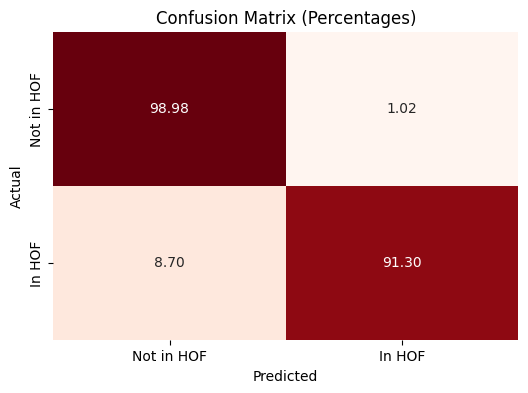

In [6889]:
confusion_mtx = confusion_matrix(y_test, pred3['Predicted'])
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx_percent, annot=True, fmt='.2f', cmap='Reds', cbar=False,
            xticklabels=['Not in HOF', 'In HOF'],
            yticklabels=['Not in HOF', 'In HOF'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentages)')
plt.show()

The results show major improvement in accurately predicting players in the HOF, but I still want to see the incorrect results and figure out why they occured. 

In [6890]:
# print out all the missed predictions
for index, row in pred3.iterrows():
    player_id = row['Player ID']
    actual_result = careers.loc[careers['player_id'] == player_id, 'hof'].values[0]
    predicted_result = row['Predicted']
    if actual_result == True and predicted_result == False:
        player = careers.loc[careers['player_id'] == player_id, 'player'].values[0]
        print(f"Player ID: {player_id}, Player: {player}, Predicted: {predicted_result}, Actual: {actual_result}")
    if actual_result == False and predicted_result == True:
        player = careers.loc[careers['player_id'] == player_id, 'player'].values[0]
        print(f"Player ID: {player_id}, Player: {player}, Predicted: {predicted_result}, Actual: {actual_result}")

Player ID: 3218, Player: Shawn Marion, Predicted: True, Actual: False
Player ID: 1021, Player: Phil Jackson, Predicted: False, Actual: True
Player ID: 1767, Player: Marques Johnson, Predicted: True, Actual: False
Player ID: 1323, Player: Rudy Tomjanovich, Predicted: False, Actual: True


After looking at these, I can conclude the model was extremely accurate. 
- Phil Jackson and Rudy Tomjanovich are in the HOF for being legendary coaches.
- Shawn Marion and Marques Johnson are often regarded as two of the best NBA players to not be inducted. Ultimately, people make the decision instead of stats, so there will always be debate. 

With these considerations in mind, I feel comfortable predicting Hall of Fame status with this model and it will be more than adequate for the next step of assigning a percentage chance of making the Hall of Fame to each actve player. 

First, lets see if the model can predict the 2023 Hall of Fame class that just got inducted (as of now, not updated in the data)

In [6852]:
class_of_2023 = careers[careers['last year'] == 2019] # players retired 4 full seasons ago
predictions = load_and_predict('trained_rfc2.pkl', class_of_2023, features, response)
print('2023 Hall of Fame Class:')
for index, row in predictions.iterrows():
    player_id = row['Player ID']
    predicted_result = row['Predicted']
    if predicted_result:
        player = careers.loc[careers['player_id'] == player_id, 'player'].values[0]
        print(player)

2023 Hall of Fame Class:
Dirk Nowitzki
Dwyane Wade
Luol Deng
Pau Gasol
Tony Parker


The model almost predicted the 2023 Hall of Fame class perfectly - all were recently inducted, except Luol Deng. 
- Deng had a very long career with solid stats and 2 all-star games and he can still make it in the future. Personally, I would not include him in the HOF, but I understand why the model predicted it. 

## Percentage Chance of Active Players

To calculate each active players chance of making the Hall of Fame if they retired today, I will use the model I have saved with a feature of Random Forest to assign the probabilities. 

In [6857]:
# function for assigning percentages
def chance(saved_model_path, new_player_data, features, response_variable):
    loaded_model = joblib.load(saved_model_path)
    x, y, id = encode_and_scale(new_player_data, features, response_variable)
    probabilities = loaded_model.predict_proba(x)
    players = careers.loc[careers['player_id'].isin(id), 'player'].tolist()
    probabilities_df = pd.DataFrame({'Player ID': id, 'Player': players, 'HOF Chance': probabilities[:, 1]})
    return probabilities_df

In [6891]:
# predict active players
active = careers[careers['last year'] == 2023]
# some players are getting in that barely played but their per minute stats are overwhelming so I need to edit again
# I will use the same criteria from earlier - substantial amount of games played
active = active[active['years played'] > 5]
active = active[active['g'] > 300]
probabilities = chance('trained_rfc2.pkl', active, features, response).round(2)
probabilities = probabilities.sort_values(by='HOF Chance', ascending=False)
probabilities.head()

,Player ID,Player,HOF Chance
333,3463,LeBron James,1.00
215,3880,James Harden,1.00
307,3770,Kevin Durant,0.99
470,3903,Stephen Curry,0.98
89,4077,Damian Lillard,0.98


#### The top 5 look accurate. Full list will be in hof_chances_list.csv in the 'Predictions' folder.

In [6882]:
probabilities.to_csv('hofChances.csv', index=False)

## Hall of Fame Probabilities Analysis
- There is no way of measuring how accurate these probabilities are until these players retire, but to my eye, the list is nearly perfect. All of the players listed above 90% are the exact players I would consider locks to be first-ballot Hall of Famers. Everyone around 50% is a toss-up, or at least not first-ballot, in my opinion. 
- Draymond Green and Klay Thompson are the only players I would say definitely need move up. That makes sense, though, becuase they don't have the most outstanding stats and accolades, but everyone knows they were key members of a dynasty that had a lot of influence.
- I would also personally move Giannis and Jokic up, but they are still young and quite high already.
- Including championships may help these players move up the rankings, but there are other situations where it would complicate it. 